<a href="https://colab.research.google.com/github/jouinisihem/Classification-of-cancer-cells-using-neural-networks/blob/master/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification du cancer du sein avec l'algorithme KNN**

-> Le but de ce  projet est  déterminer si la cellule cancéreuse du sein est maligne ou bénigne. 



**1-importation des bibliothéques necessaires**

In [ ]:
#importation des bibliothèques nécessaires
 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
 
#GridSearchCV --> Nous l'utilisons pour trouver les meilleurs paramètres.
from sklearn.model_selection import train_test_split, GridSearchCV 
 
#pour évaluer le résultat
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
 
# Utilisé pour ignorer les alertes sans erreur
import warnings
warnings.filterwarnings("ignore")

**2-chargement,traitement et visualisation des données de cellules cancéreuses** 

B    357
M    212
Name: target, dtype: int64


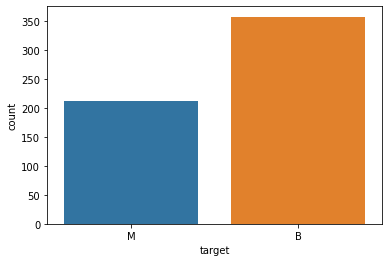

In [ ]:
# chargement des données
data = pd.read_csv("cancer.csv")
 
# Nous supprimons les fonctionnalités que nous ne voulons pas de notre projet (axis = 1 signifie drop column)
data.drop(['Unnamed: 32','id'], inplace = True, axis = 1)
 
# Nous changeons le titre des propriétés
data = data.rename(columns = {"diagnosis":"target"})
 
# NOUS COMMENCONS À EXAMINER NOS DONNÉES
 
#Nous examinons le nombre de cellules cancéreuses Bénignes et Malignes.
sns.countplot(data["target"])
print(data.target.value_counts())

In [ ]:
# Nous convertissons les expressions de chaîne en int (Bening = 0, Malignant = 1)
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target] 

# On apprend la taille des données
print("Data Shape:", data.shape) 

# maitenant nous examinons nos données
data.info() 

Data Shape: (569, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area

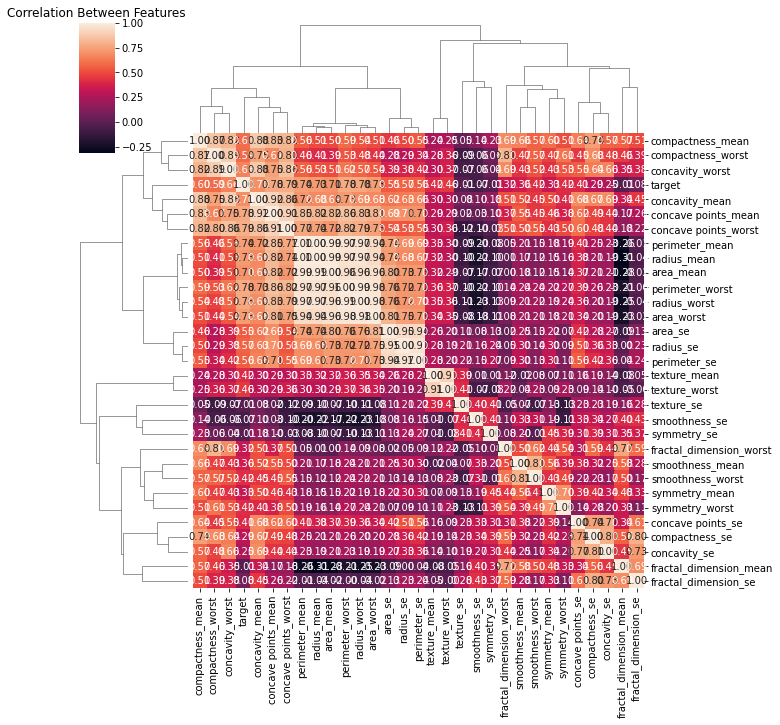

In [ ]:
"""
Dans cette étape ,nous examinons le besoin de normalisation des données, s'il y a de grandes différences entre les données, une normalisation est nécessaire.
"""
describe = data.describe()
# Nous effectuons notre analyse détaillée des données.
corr_matrix = data.corr()
#Nous examinons la relation entre les fonctionnalités.
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation Between Features")
plt.show()

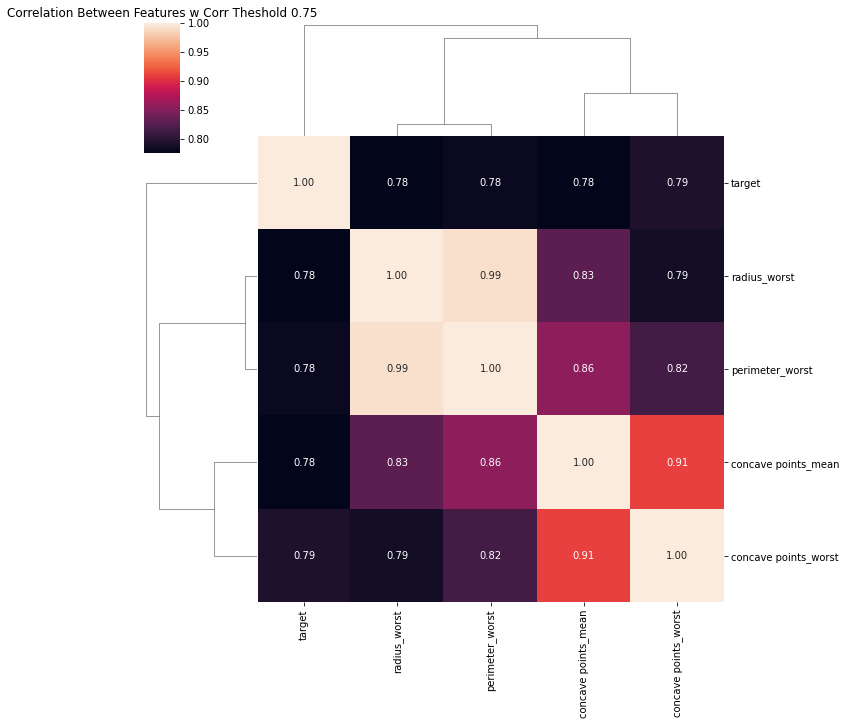

In [ ]:
"""
nous fixons une valeur limite. Ici, nous le réglons à 0,75.
Nous apportons ceux dont la relation entre les propriétés est supérieure à 0,75.
"""

threshold = 0.75 
filtre = np.abs(corr_matrix["target"]) > threshold 
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.75")
plt.show()


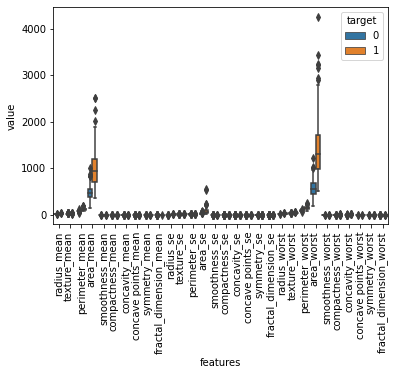

In [ ]:
"""
pd.melt -> Cela nous permet de dissoudre les données que nous avons, c'est-à-dire qu'il nous aide à collecter les colonnes que nous voulons dans une seule colonne.
      id_vars -> Nous écrivons ici quelles colonnes nous voulons.

"""
data_melted = pd.melt(data, id_vars = "target",
                      var_name = "features",
                      value_name = "value")
"""
plt.boxplot -> Ce type de graphique montre les valeurs de quartile de la distribution avec des valeurs aberrantes.
"""
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90) 
plt.show()


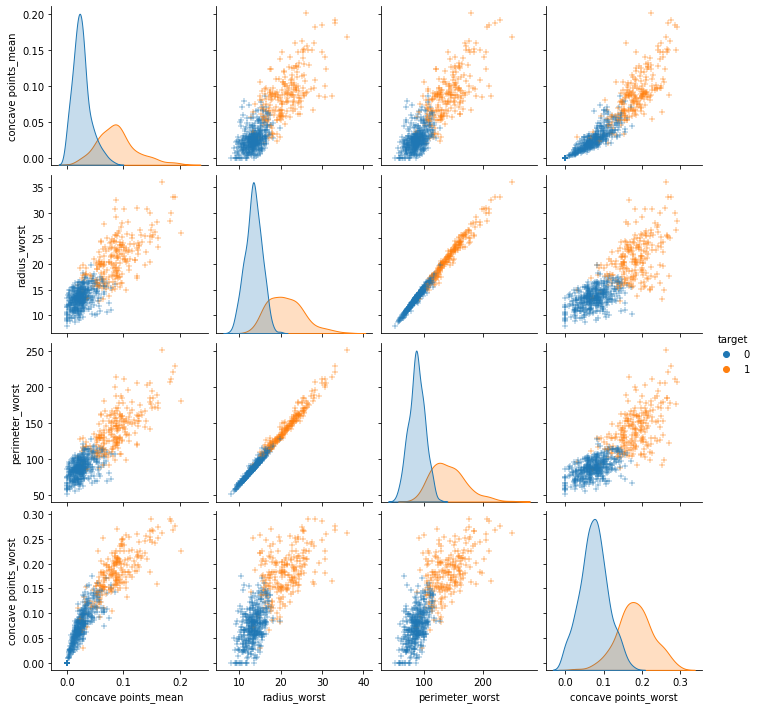

In [ ]:
"""
sns.pairplot -> Dessine des relations bidirectionnelles pour les colonnes numériques dans tout l'environnement de données.
"""
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "target")
plt.show()



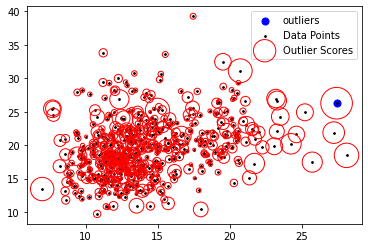

In [ ]:
"""
Nous divisons les données en deux parties, y et x. (y -> Target, x -> toutes les colonnes sauf la cible)
"""
y = data.target
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()
"""
 détecter les valeurs aberrantes(outliers).
"""
# outlier -->  Données aberrantes que les autres données de nos données.
clf = LocalOutlierFactor()
# On voit s'il est outlier ou non,-1 est outlier
y_pred = clf.fit_predict(x)
# nous avons besoin de valeurs de facteur aberrantes(outliers) (à partir de là, nous pouvons mieux observer les valeurs aberrantes(outliers))
X_score = clf.negative_outlier_factor_
#Nous créons ici un dataframe et mettons ici des valeurs de facteurs outliers
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score
# nous montrera ceux dont la valeur aberrante(outliers) est supérieure à 2,5
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()
# nous examinons la distribution des données
plt.figure()
plt.scatter(x.iloc[outlier_index,0],x.iloc[outlier_index,1],color = "blue", s = 50, label = "outliers")
plt.scatter(x.iloc[:,0],x.iloc[:,1],color = "k", s = 3, label = "Data Points")
# Nous faisons la normalisation pour le processus de traçage
radius = (X_score.max()- X_score) / (X_score.max() - X_score.min())
outlier_score["radius"] = radius
# nous examinons le diamètre des cellules cancéreuses
plt.scatter(x.iloc[:,0],x.iloc[:,1],s = 1000*radius, edgecolors = "r", facecolors = "none", label = "Outlier Scores")
plt.legend() 
plt.show()
# drop outlier
x = x.drop(outlier_index)
y = y.drop(outlier_index).values


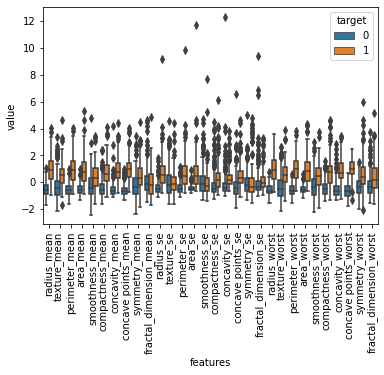

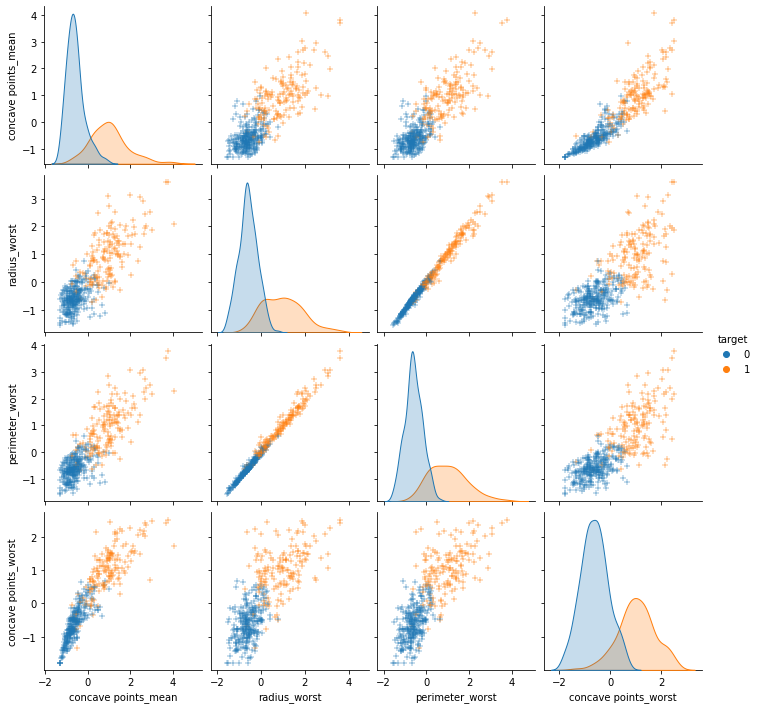

In [ ]:
#Train test split -> Nous séparons nos données de test et de training
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)
# standrization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df_describe = X_train_df.describe()
X_train_df["target"] = Y_train
"""
pd.melt -> Cela nous permet de dissoudre les données que nous avons, c'est-à-dire qu'il nous aide à collecter les colonnes que nous voulons dans une seule colonne.
      id_vars -> Nous écrivons ici quelles colonnes nous voulons.

"""
data_melted = pd.melt(X_train_df, id_vars = "target",
                      var_name = "features",
                      value_name = "value")
# Nous examinons nos données en visualisant

plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()
sns.pairplot(X_train_df[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()
 

**3**-**Classification des tumeurs on Utilison  l'algorithme KNN**





In [ ]:
"""
 A ce niveau la ,Nous incluons l'algorithme de classification knn que nous utiliserons dans notre projet.
"""

# Nous déterminons le nombre de voisins comme 2 et créons notre objet.
knn = KNeighborsClassifier(n_neighbors = 2)
# train  algorithm.
knn.fit(X_train, Y_train)
# Maintenant que notre modèle est prêt, il fait une prédiction.
y_pred = knn.predict(X_test)
# Nous examinons à quel point nous prédisons bien et mal.
cm = confusion_matrix(Y_test, y_pred)

# Nous regardons notre score de réussite.
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)

print("Score : ", score)
print("CM : ", cm)
print("Basic KNN Acc : ", acc)
# Nous devons déterminer les meilleurs paramètres. Nous déterminons les meilleurs paramètres pour notre projet à l'aide de la fonction ci-dessous.
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    
    # Nous écrivons les paramètres à tester pour l'algorithme knn. Nous trouverons le meilleur parmi ces paramètres.
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    
    knn = KNeighborsClassifier()
    knn = KNeighborsClassifier()
    
    # En utilisant GridSearchCV, nous trouvons nos meilleurs paramètres.
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    # grid.best_score_ -> donne le meilleur score. grid.best_params_ -> donne les paramètres renvoyant le meilleur score.
    print("Best training score : {} with paremeters : {}".format(grid.best_score_, grid.best_params_))
    print()
    knn = KNeighborsClassifier(**grid.best_params_) 
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test) 
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)
    
    return grid
    # Nous envoyons nos données en appelant la fonction que nous avons écrite.
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test) 

Score :  0.9532163742690059
CM :  [[108   1]
 [  7  55]]
Basic KNN Acc :  0.9532163742690059

Best training score : 0.9670512820512821 with paremeters : {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.9590643274853801, Train Score: 0.9773299748110831

CM Test:  [[107   2]
 [  5  57]]
CM Train:  [[248   0]
 [  9 140]]


**4-distribution des tumeurs bénignes et malignes après PCA**





Best training score : 0.9419230769230769 with paremeters : {'n_neighbors': 9, 'weights': 'uniform'}

Test Score: 0.9239766081871345, Train Score: 0.947103274559194

CM Test:  [[103   6]
 [  7  55]]
CM Train:  [[241   7]
 [ 14 135]]


Text(0.5, 1.0, "2-Class classification (k = 9, weights = 'uniform')")

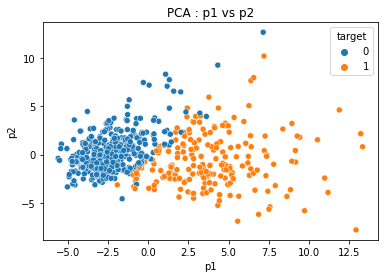

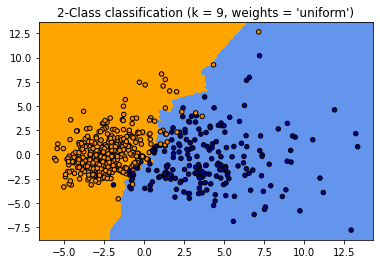

In [ ]:

# PCA
"""
PCA -> La méthode qui réduit la taille des données en conservant autant d'informations que possible. Nous pouvons réduire certaines fonctionnalités.
"""
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#Nous réduisons 30 fonctionnalités à 2
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y


sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA : p1 vs p2")
# nous nous recyclons maintenant que nous avons un nouvel ensemble de données(dataset)
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y, test_size = test_size, random_state = 42)

# Nous envoyons nos données en appelant la fonction que nous avons écrite.
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)

# Nous effectuons le processus de visualisation ici. Nous choisissons 4 couleurs
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .05 #  h est la taille de pas dans le maillage
X = X_reduced_pca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])


# Mettez le résultat dans un tracé de couleur
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Tracez également les points d'entraînement
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))




**5-Distribution des tumeurs bénignes et malignes après NCA (maximisation des performance de classification)**


Best training score : 0.9873076923076922 with paremeters : {'n_neighbors': 1, 'weights': 'uniform'}

Test Score: 0.9941520467836257, Train Score: 1.0

CM Test:  [[108   1]
 [  0  62]]
CM Train:  [[248   0]
 [  0 149]]


Text(0.5, 1.0, "2-Class classification (k = 1, weights = 'uniform')")

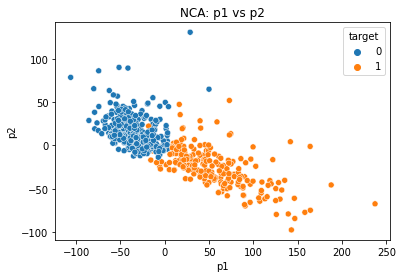

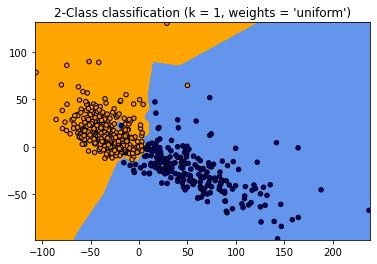

In [ ]:
# NCA
"""
NCA --> Changements linéaires des données d'entrée pour maximiser les performances de classification.
apprendre la métrique de distance en utilisant la transformation.

"""

nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
sns.scatterplot(x = "p1",  y = "p2", hue = "target", data = nca_data)
plt.title("NCA: p1 vs p2")

X_train_nca, X_test_nca, Y_train_nca, Y_test_nca = train_test_split(X_reduced_nca, y, test_size = test_size, random_state = 42)

grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, Y_train_nca, Y_test_nca)

cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .2 # h: taille de pas dans le maillage
X = X_reduced_nca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

# Mettez le résultat dans un tracé de couleur
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Tracez également les points d'entraînement
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights))



**6-Classement et Prédiction**

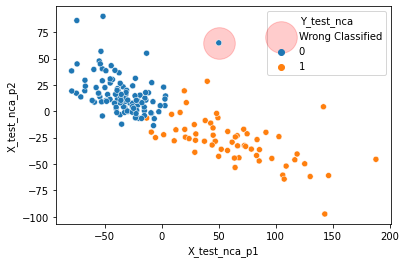

In [ ]:
# nous trouvons les mauvaises classifications que nous avons faites.
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,Y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca,Y_test_nca)
knn.score(X_test_nca,Y_test_nca)


test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = Y_test_nca

plt.figure()
diff = np.where(y_pred_nca!=Y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0],test_data.iloc[diff,1],label = "Wrong Classified",alpha = 0.2,color = "red",s = 1000)

sns.scatterplot(x="X_test_nca_p1", y="X_test_nca_p2", hue="Y_test_nca",data=test_data)